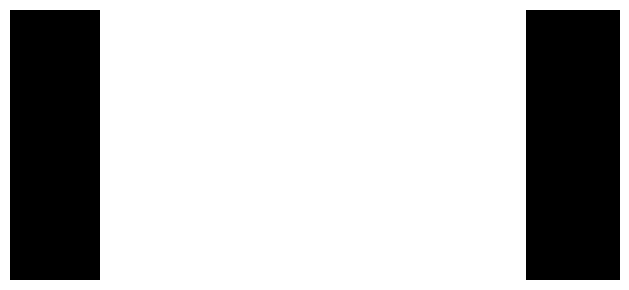

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def preprocess_image(img_path):
    # Load image in grayscale
    gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Threshold to binary (0: black/foreground, 255: white/background)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Invert: foreground white, background black
    binary = 255 - binary

    # Thinning
    from skimage.morphology import skeletonize
    skeleton = skeletonize(binary // 255).astype(np.uint8) * 255

    # Remove small noise using morphological opening
    kernel = np.ones((2, 2), np.uint8)
    cleaned = cv2.morphologyEx(skeleton, cv2.MORPH_OPEN, kernel)

    return cleaned

def get_segmentation_columns(binary_img, threshold=7):
    height, width = binary_img.shape
    psc_indices = []

    # Count foreground pixels in each column
    for x in range(width):
        col = binary_img[:, x]
        white_pixels = np.count_nonzero(col)  # white pixels are foreground (255)
        if white_pixels <= 1:
            psc_indices.append(x)

    # Merge close PSCs into SCs
    sc_indices = []
    if not psc_indices:
        return sc_indices

    group = [psc_indices[0]]
    for i in range(1, len(psc_indices)):
        if psc_indices[i] - psc_indices[i - 1] <= threshold:
            group.append(psc_indices[i])
        else:
            avg = sum(group) // len(group)
            sc_indices.append(avg)
            group = [psc_indices[i]]
    if group:
        avg = sum(group) // len(group)
        sc_indices.append(avg)

    return sc_indices

def segment_characters(binary_img, sc_indices, output_dir="segments"):
    os.makedirs(output_dir, exist_ok=True)
    segments = []
    start = 0

    sc_indices = sorted(set(sc_indices + [binary_img.shape[1] - 1]))  # Add last boundary

    for i, end in enumerate(sc_indices):
        char_img = binary_img[:, start:end]
        if char_img.shape[1] > 2:  # Ignore very narrow cuts
            segments.append(char_img)
            filename = os.path.join(output_dir, f"char_{i:02d}.png")
            cv2.imwrite(filename, 255 - char_img)  # Re-invert for saving
        start = end

    return segments

def plot_segments(segments):
    plt.figure(figsize=(15, 3))
    for i, char_img in enumerate(segments):
        plt.subplot(1, len(segments), i + 1)
        plt.imshow(char_img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- Usage Example ---
img_path = r"C:\Users\JAI SHREE KRISHNA\Major Project\cropped_words\line01_word000.png"  # Replace with your image path

binary = preprocess_image(img_path)
scs = get_segmentation_columns(binary, threshold=7)
segments = segment_characters(binary, scs)
plot_segments(segments)


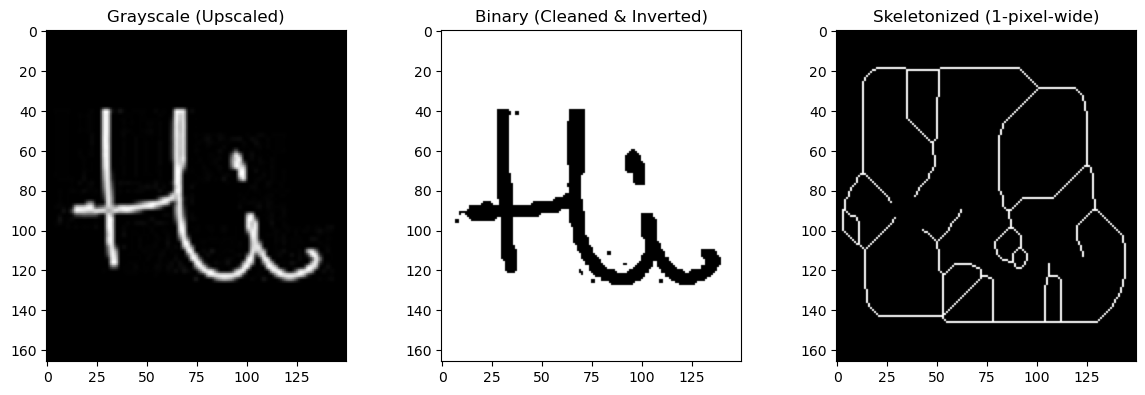


🖼️ Word Image: line01_word000.png
🔤 Predicted: ?


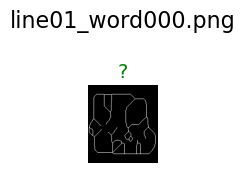

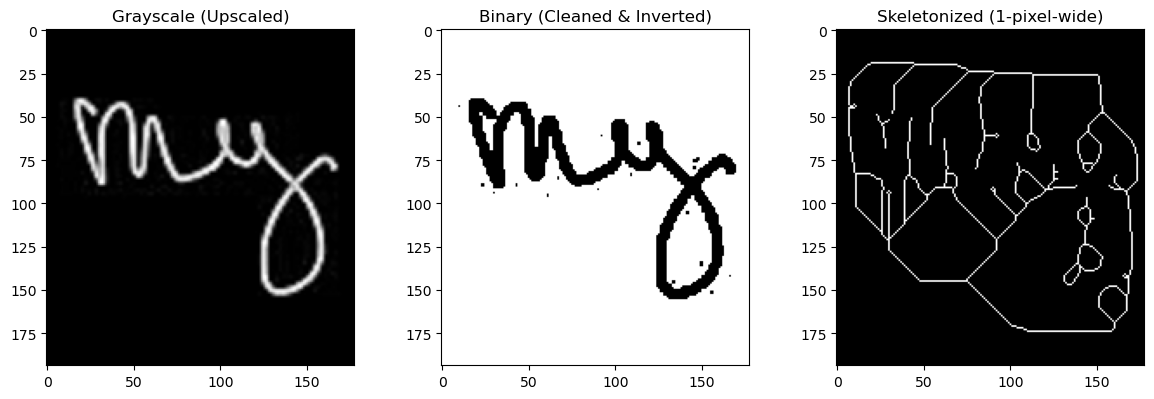


🖼️ Word Image: line01_word001.png
🔤 Predicted: ??


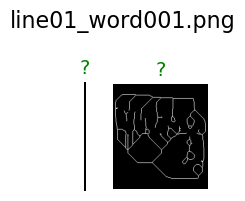

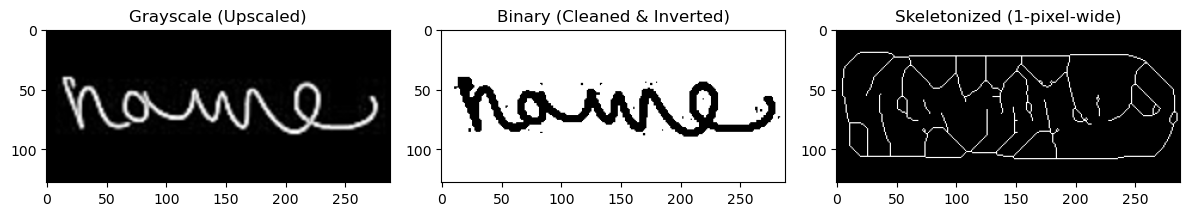


🖼️ Word Image: line01_word002.png
🔤 Predicted: ?


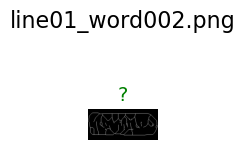

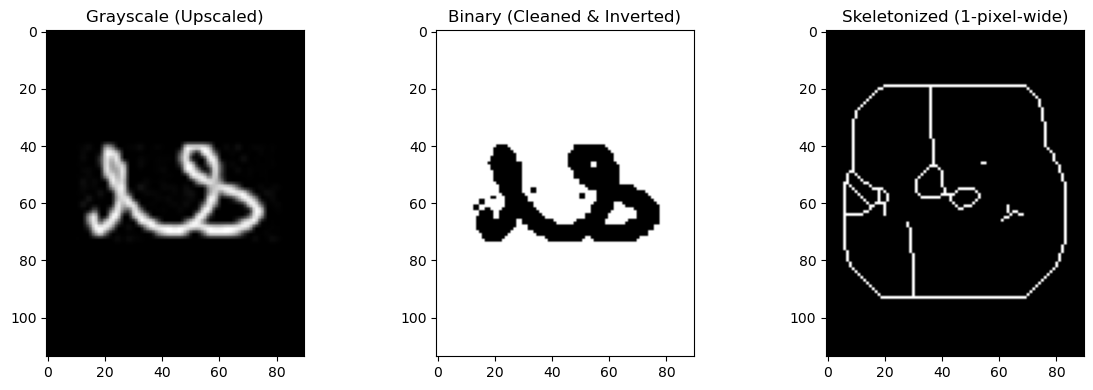


🖼️ Word Image: line01_word003.png
🔤 Predicted: ??


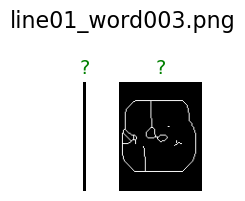

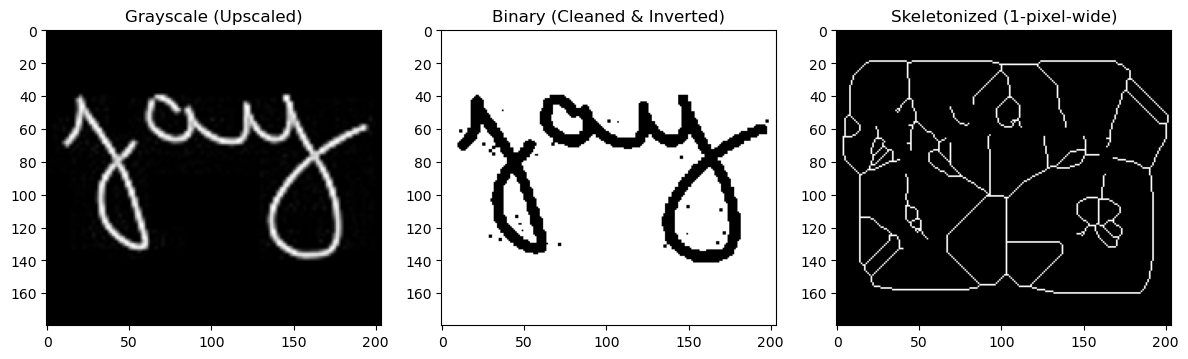


🖼️ Word Image: line01_word004.png
🔤 Predicted: ?


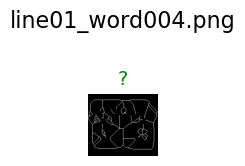

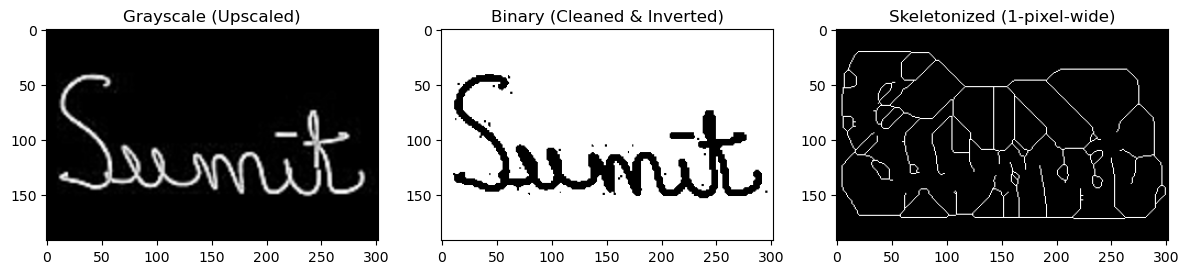


🖼️ Word Image: line02_word005.png
🔤 Predicted: ?


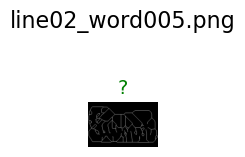

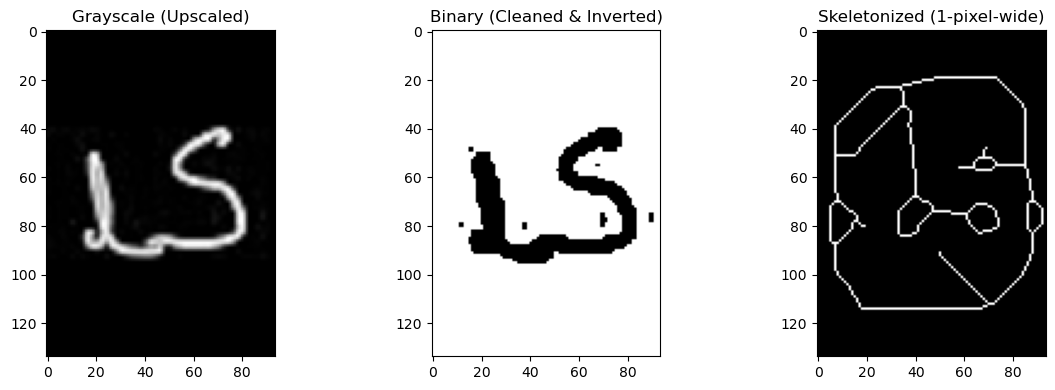


🖼️ Word Image: line02_word006.png
🔤 Predicted: ?


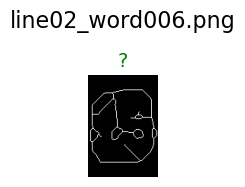

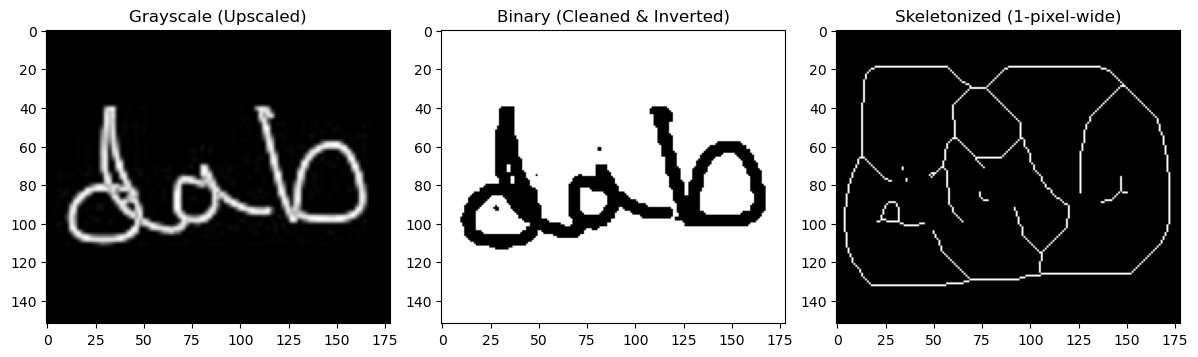


🖼️ Word Image: line02_word007.png
🔤 Predicted: ?


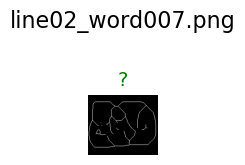

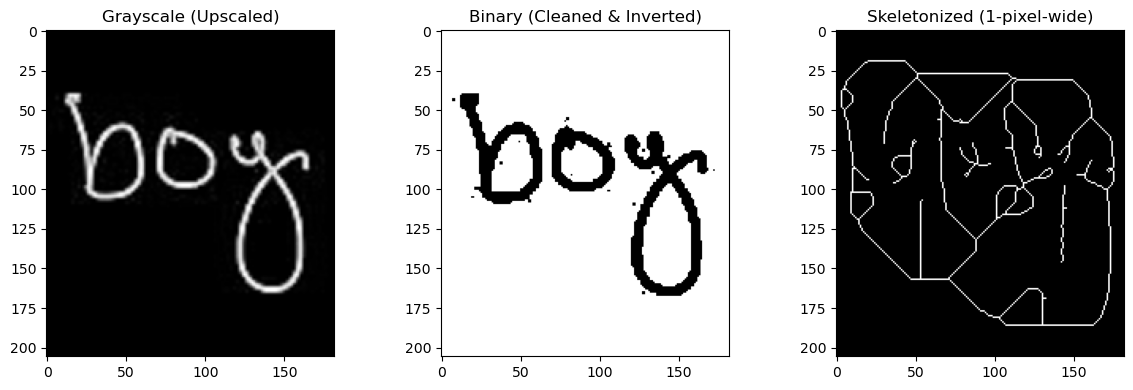


🖼️ Word Image: line02_word008.png
🔤 Predicted: ?


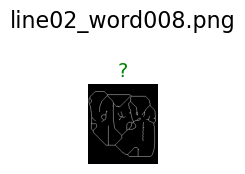

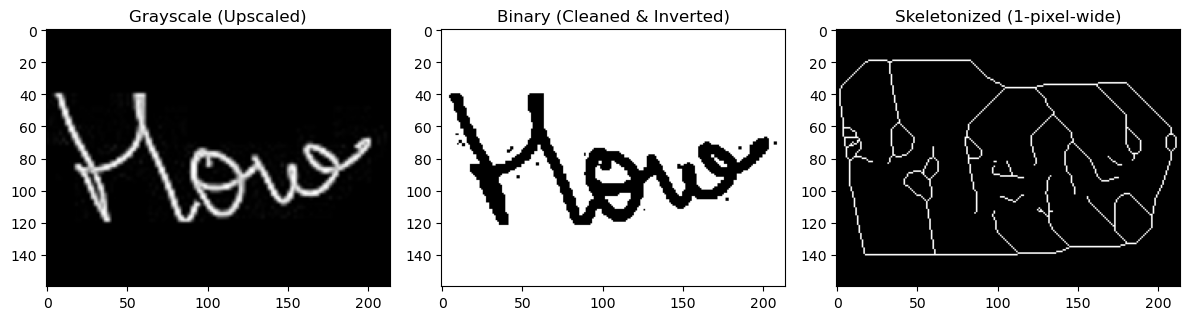


🖼️ Word Image: line03_word009.png
🔤 Predicted: ?


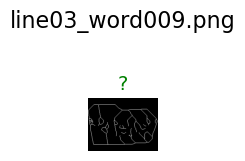

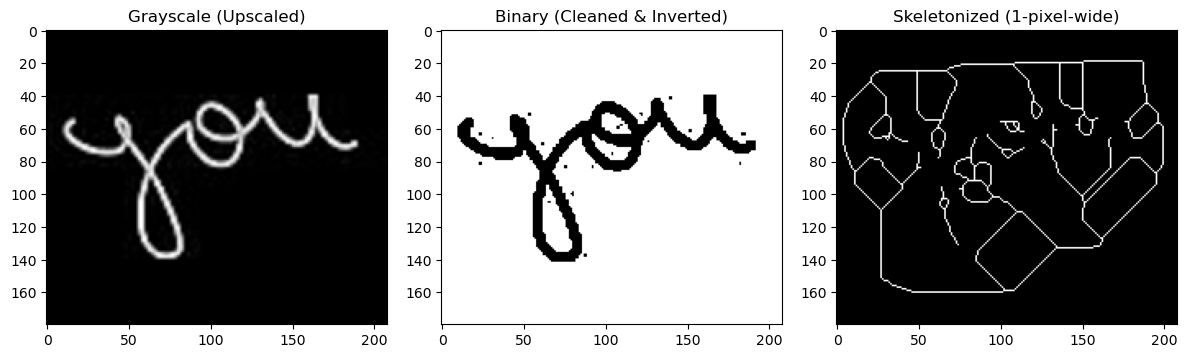


🖼️ Word Image: line03_word010.png
🔤 Predicted: ?


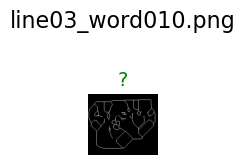

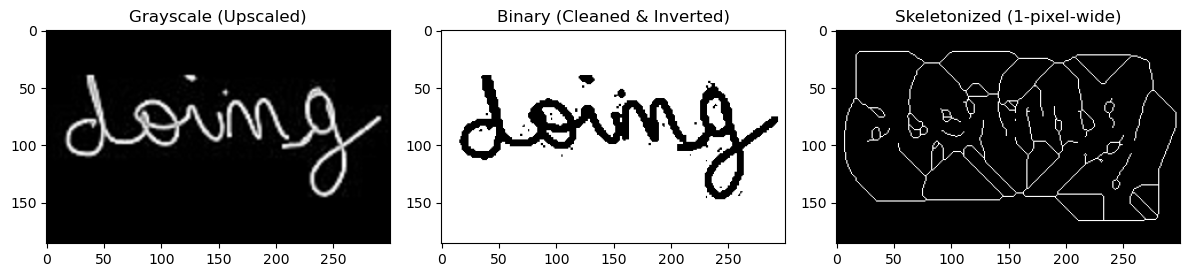


🖼️ Word Image: line03_word011.png
🔤 Predicted: ??


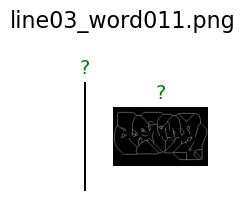

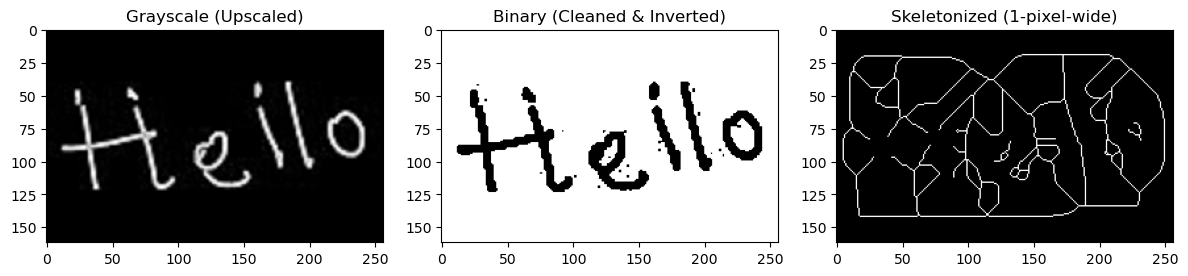


🖼️ Word Image: line04_word012.png
🔤 Predicted: ?


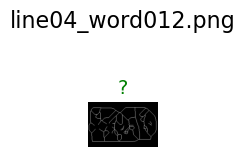

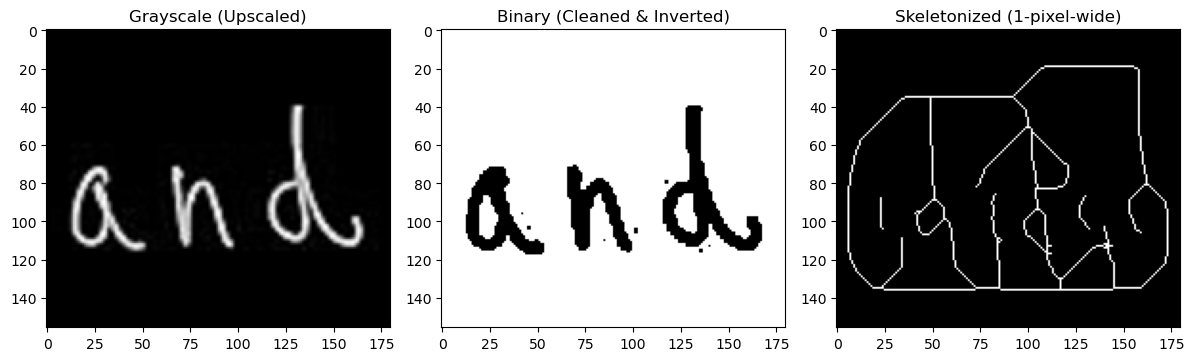


🖼️ Word Image: line04_word013.png
🔤 Predicted: ??


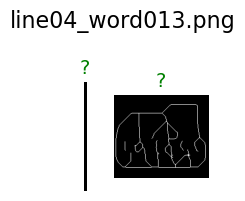

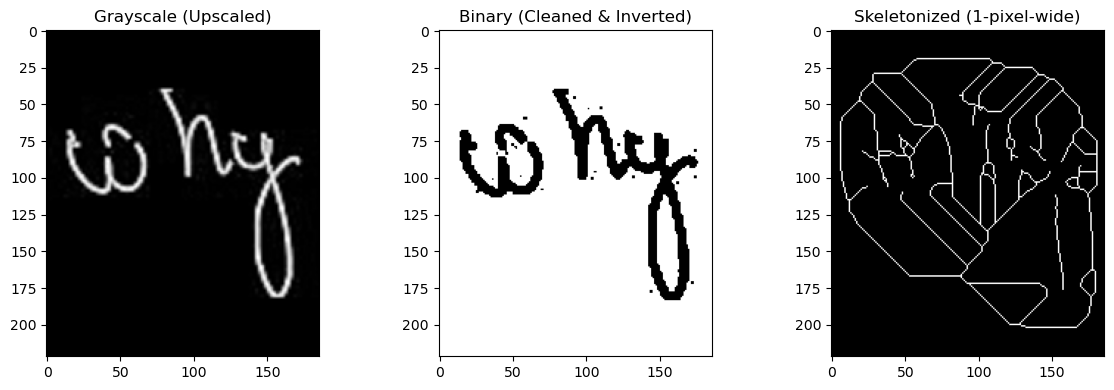


🖼️ Word Image: line04_word014.png
🔤 Predicted: ??


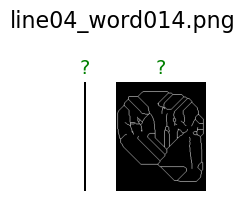

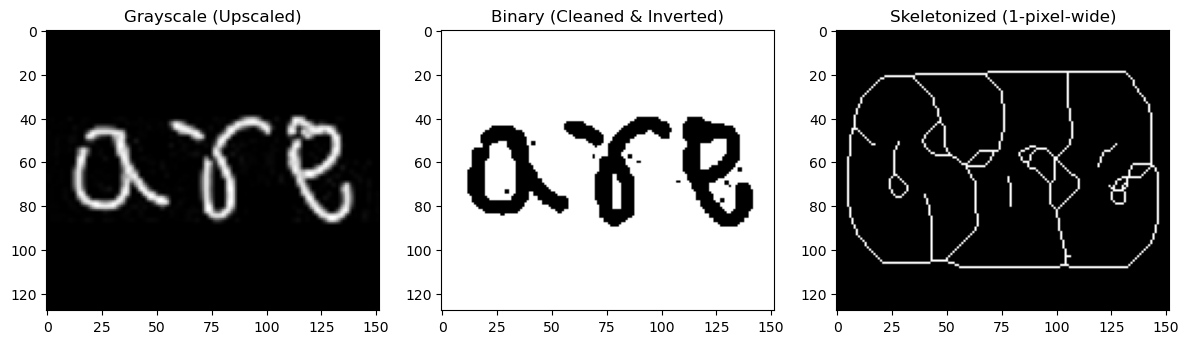


🖼️ Word Image: line04_word015.png
🔤 Predicted: ?


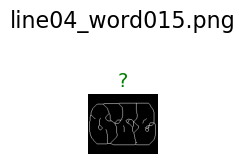

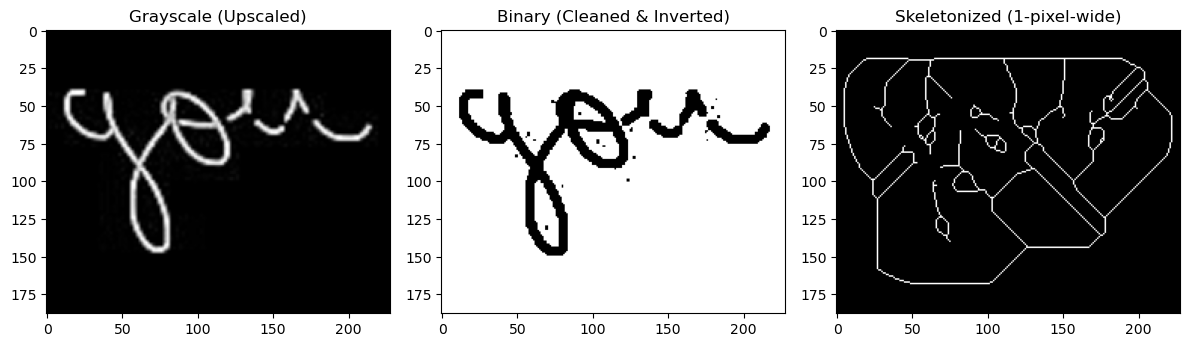


🖼️ Word Image: line04_word016.png
🔤 Predicted: ?


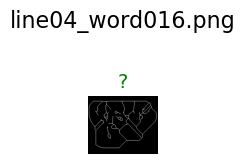

In [3]:
import os
import cv2
import glob
import numpy as np
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt

kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
def visualize_segments(segments, predictions=None, title="Segments"):
    plt.figure(figsize=(len(segments), 2))
    for i, img in enumerate(segments):
        plt.subplot(1, len(segments), i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        if predictions:
            plt.title(predictions[i], fontsize=14, color='green')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# === Step 1: Model Prediction Stub ===
def predict_character(img):
    # Resize and normalize image for model input
    img_resized = cv2.resize(img, (28, 28))
    img_normalized = img_resized / 255.0
    # Expand dims if needed: img_input = np.expand_dims(img_normalized, axis=[0, -1])
    # prediction = model.predict(img_input)
    # Replace below line with actual prediction
    return "?"  # Dummy character

# === Step 2: Preprocessing ===
from skimage.morphology import skeletonize
from skimage.util import invert

def preprocess_image_array(img):
    # STEP 1 — Make sure it's grayscale
    gray = img if len(img.shape) == 2 else cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # ✅ Fix 3: Upscale the image to help preserve structure
    gray = cv2.resize(gray, (0, 0), fx=2.0, fy=2.0, interpolation=cv2.INTER_LINEAR)

    # STEP 2 — Binarize using Otsu's method
    _, binary = cv2.threshold(gray, 12, 255, cv2.THRESH_BINARY)
 

    # ✅ Fix 2: Invert to make text white on black (foreground = white)
    binary = 255 - binary

    # Optional: Clean noise if needed
    kernel = np.ones((2, 2), np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # ✅ Fix 1: Convert to boolean mask for skeletonize
    bool_img = cleaned > 0  # foreground = True

    # Skeletonize (returns boolean image where True = 1-pixel-wide strokes)
    skeleton = skeletonize(bool_img)

    # Convert to displayable image (uint8)
    skeleton_uint8 = (skeleton * 255).astype(np.uint8)

    # Optional — Visual check (recommended while testing)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale (Upscaled)")

    plt.subplot(1, 3, 2)
    plt.imshow(cleaned, cmap='gray')
    plt.title("Binary (Cleaned & Inverted)")

    plt.subplot(1, 3, 3)
    plt.imshow(skeleton_uint8, cmap='gray')
    plt.title("Skeletonized (1-pixel-wide)")

    plt.tight_layout()
    plt.show()

    return skeleton_uint8



# === Step 3: PSC-based Vertical Segmentation ===
def get_segmentation_columns(binary_img, threshold=7):
    psc_indices = []
    for x in range(binary_img.shape[1]):
        col = binary_img[:, x]
        if np.count_nonzero(col == 255) <= 1:
            psc_indices.append(x)

    sc_indices = []
    if not psc_indices:
        return sc_indices

    group = [psc_indices[0]]
    for i in range(1, len(psc_indices)):
        if psc_indices[i] - psc_indices[i - 1] <= threshold:
            group.append(psc_indices[i])
        else:
            avg = sum(group) // len(group)
            sc_indices.append(avg)
            group = [psc_indices[i]]
    if group:
        sc_indices.append(sum(group) // len(group))
    return sc_indices

# === Step 4: Segment by SCs ===
def segment_characters(binary_img, sc_indices, min_width=5):
    segments = []
    start = 0
    sc_indices = sorted(set(sc_indices + [binary_img.shape[1] - 1]))
    for end in sc_indices:
        width = end - start
        if width >= min_width:
            segments.append(binary_img[:, start:end])
        start = end
    return segments

# === Step 5: Fallback Projection-Based Segmentation ===
def fallback_segmentation(binary_img, min_gap=5):
    col_sum = np.sum(binary_img == 255, axis=0)
    cut_points = []
    in_gap = False
    for i, val in enumerate(col_sum):
        if val == 0 and not in_gap:
            gap_start = i
            in_gap = True
        elif val > 0 and in_gap:
            gap_end = i
            if gap_end - gap_start >= min_gap:
                cut_points.append((gap_start + gap_end) // 2)
            in_gap = False

    cut_points = [0] + cut_points + [binary_img.shape[1]]
    segments = []
    for i in range(len(cut_points) - 1):
        left, right = cut_points[i], cut_points[i + 1]
        if right - left > 2:
            segments.append(binary_img[:, left:right])
    return segments

# === Step 6: Visualize (optional) ===


# === Step 7: Main Batch Pipeline ===
def run_pipeline(image_folder="data/words"):
    os.makedirs(image_folder, exist_ok=True)
    word_images = sorted(glob.glob(os.path.join(image_folder, "*.png")))

    for img_path in word_images:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"⚠️ Could not load image: {img_path}")
            continue
        img = cv2.filter2D(img, -1, kernel)
        preprocessed = preprocess_image_array(img)

        # Use fallback projection-based segmentation
        segments = fallback_segmentation(preprocessed, min_gap=2)

        predicted_chars = [predict_character(seg) for seg in segments]

        print(f"\n🖼️ Word Image: {os.path.basename(img_path)}")
        print(f"🔤 Predicted: {''.join(predicted_chars)}")

        visualize_segments(segments, predictions=predicted_chars, title=os.path.basename(img_path))

def medial_axis_skeleton(img_path):
    # Load grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError("Image could not be loaded.")

    # Optional: resize for clarity
    img = cv2.resize(img, (0, 0), fx=2.0, fy=2.0, interpolation=cv2.INTER_LINEAR)

    # Threshold with inversion: foreground should be white
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary = 255 - binary

    # Optional: denoise slightly
    kernel = np.ones((2, 2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # Medial axis skeletonization (returns boolean skeleton + distance map)
    skeleton, distance = medial_axis(binary > 0, return_distance=True)
    skeleton_img = (skeleton * 255).astype(np.uint8)

    # Visualize
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original")

    plt.subplot(1, 3, 2)
    plt.imshow(binary, cmap='gray')
    plt.title("Binary (White Foreground)")

    plt.subplot(1, 3, 3)
    plt.imshow(skeleton_img, cmap='gray')
    plt.title("Medial Axis Skeleton")

    plt.tight_layout()
    plt.show()

    return skeleton_img
# === Run It ===
path = r"C:\Users\JAI SHREE KRISHNA\Major Project\cropped_words"
run_pipeline(path)  # Replace with your folder path


In [36]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt

# Load original grayscale image
img = cv2.imread(r"C:\Users\JAI SHREE KRISHNA\Major Project\cropped_words\line01_word000.png", cv2.IMREAD_GRAYSCALE)


# Resize (optional, but helps tiny strokes)
img = cv2.resize(img, (0, 0), fx=2.0, fy=2.0, interpolation=cv2.INTER_LINEAR)

# Step 1: Binarize with inversion (foreground = white, background = black)
_, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
binary = 255 - binary  # Make text white

# Step 2: Remove small noise
cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((2, 2), np.uint8))

# Step 3: Convert to boolean

# Thicken strokes to fill hollow letters
kernel = np.ones((2, 2), np.uint8)
filled = cv2.dilate(cleaned, kernel, iterations=1)

# Convert to boolean
bool_img = filled > 0
# Step 4: Apply skeletonization (skimage guarantees 1-pixel-wide centerline)
skeleton = skeletonize(bool_img)

# Step 5: Convert to displayable image
skeleton_uint8 = (skeleton * 255).astype(np.uint8)

# Visualize
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Grayscale")

plt.subplot(1, 3, 2)
plt.imshow(cleaned, cmap='gray')
plt.title("Cleaned Binary")

plt.subplot(1, 3, 3)
plt.imshow(skeleton_uint8, cmap='gray')
plt.title("Skeleton (1-pixel)")

plt.tight_layout()
plt.show()


NameError: name 'gray' is not defined

In [51]:
import os
import cv2
import glob
import numpy as np
from skimage.morphology import medial_axis
import matplotlib.pyplot as plt

def preprocess_image_array(img):
    # Skip resize — keep original shape
    gray = img if len(img.shape) == 2 else cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Clean binary using adaptive threshold
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 15, 8
    )

    # Morph to remove noise, smooth
    kernel = np.ones((2, 2), np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    return cleaned  # DO NOT skeletonize



def visualize_segments(segments, predictions=None, title="Segments"):
    plt.figure(figsize=(len(segments), 2))
    for i, img in enumerate(segments):
        plt.subplot(1, len(segments), i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        if predictions:
            plt.title(predictions[i], fontsize=14, color='green')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def fallback_segmentation(binary_img, min_gap=2):
    col_sum = np.sum(binary_img == 255, axis=0)
    cut_points = []
    in_gap = False
    for i, val in enumerate(col_sum):
        if val == 0 and not in_gap:
            gap_start = i
            in_gap = True
        elif val > 0 and in_gap:
            gap_end = i
            if gap_end - gap_start >= min_gap:
                cut_points.append((gap_start + gap_end) // 2)
            in_gap = False
    cut_points = [0] + cut_points + [binary_img.shape[1]]
    segments = []
    for i in range(len(cut_points) - 1):
        left, right = cut_points[i], cut_points[i + 1]
        if right - left > 2:
            segments.append(binary_img[:, left:right])
    return segments
def contour_segmentation(binary_img, min_area=50):
    contours, _ = cv2.findContours(binary_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    segments = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w * h >= min_area:
            char = binary_img[y:y+h, x:x+w]
            segments.append((x, char))
    # Sort left to right
    segments = [char for x, char in sorted(segments, key=lambda tup: tup[0])]
    return segments

def predict_character(img):
    resized = cv2.resize(img, (28, 28))
    normalized = resized / 255.0
    return "?"  # Replace with your model output

def run_pipeline(image_folder="data/words"):
    os.makedirs(image_folder, exist_ok=True)
    word_images = sorted(glob.glob(os.path.join(image_folder, "*.png")))
    
    print(f"📂 Looking in: {image_folder}")
    print(f"🖼️ Found {len(word_images)} PNG images.")

    if len(word_images) == 0:
        print("❌ No images found. Check folder path or file extensions.")
        return

    for img_path in word_images:
        print(f"\n🔍 Processing: {os.path.basename(img_path)}")
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"⚠️ Failed to load: {img_path}")
            continue

        preprocessed = preprocess_image_array(img)

        # Debug: Show preprocessed skeleton shape & pixel count
        print("🧪 Skeleton shape:", preprocessed.shape, 
              "| White pixels:", np.count_nonzero(preprocessed == 255))

        segments = contour_segmentation(preprocessed)
        print(f"✂️ Segments found: {len(segments)}")

        if not segments:
            print("⚠️ No characters detected. Skipping image.")
            continue

        predicted_chars = [predict_character(seg) for seg in segments]

        print(f"🔤 Predicted: {''.join(predicted_chars)}")

        visualize_segments(segments, predictions=predicted_chars, title=os.path.basename(img_path))



📂 Looking in: C:\Users\JAI SHREE KRISHNA\Major Project\cropped_words
🖼️ Found 17 PNG images.

🔍 Processing: line01_word000.png
🧪 Skeleton shape: (83, 75) | White pixels: 1178
✂️ Segments found: 4
🔤 Predicted: ????


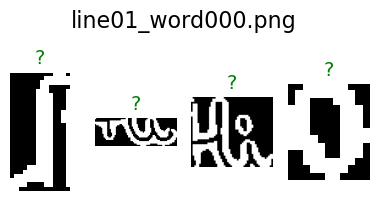


🔍 Processing: line01_word001.png
🧪 Skeleton shape: (97, 89) | White pixels: 1584
✂️ Segments found: 1
🔤 Predicted: ?


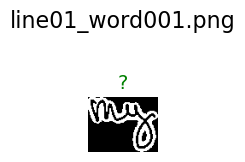


🔍 Processing: line01_word002.png
🧪 Skeleton shape: (64, 144) | White pixels: 1788
✂️ Segments found: 1
🔤 Predicted: ?


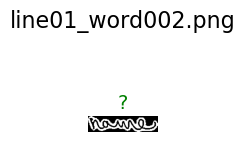


🔍 Processing: line01_word003.png
🧪 Skeleton shape: (57, 45) | White pixels: 482
✂️ Segments found: 1
🔤 Predicted: ?


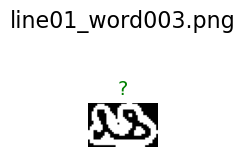


🔍 Processing: line01_word004.png
🧪 Skeleton shape: (90, 102) | White pixels: 1979
✂️ Segments found: 4
🔤 Predicted: ????


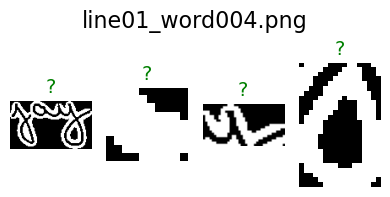


🔍 Processing: line02_word005.png
🧪 Skeleton shape: (96, 151) | White pixels: 2694
✂️ Segments found: 1
🔤 Predicted: ?


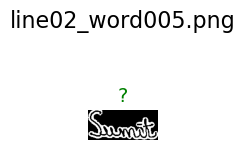


🔍 Processing: line02_word006.png
🧪 Skeleton shape: (67, 47) | White pixels: 658
✂️ Segments found: 1
🔤 Predicted: ?


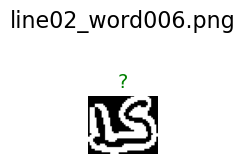


🔍 Processing: line02_word007.png
🧪 Skeleton shape: (76, 89) | White pixels: 1482
✂️ Segments found: 1
🔤 Predicted: ?


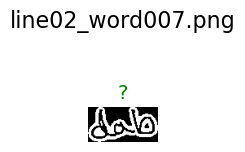


🔍 Processing: line02_word008.png
🧪 Skeleton shape: (103, 91) | White pixels: 1855
✂️ Segments found: 2
🔤 Predicted: ??


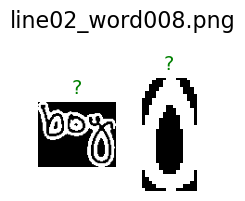


🔍 Processing: line03_word009.png
🧪 Skeleton shape: (80, 107) | White pixels: 1645
✂️ Segments found: 1
🔤 Predicted: ?


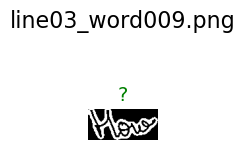


🔍 Processing: line03_word010.png
🧪 Skeleton shape: (90, 104) | White pixels: 1509
✂️ Segments found: 4
🔤 Predicted: ????


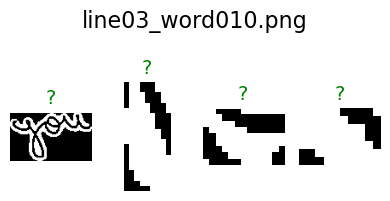


🔍 Processing: line03_word011.png
🧪 Skeleton shape: (93, 150) | White pixels: 2529
✂️ Segments found: 7
🔤 Predicted: ???????


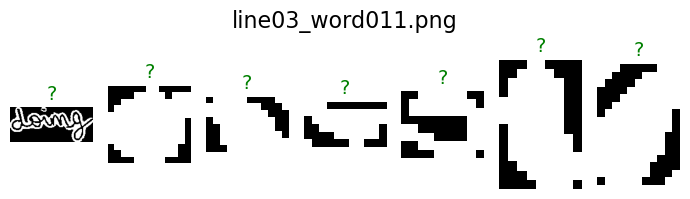


🔍 Processing: line04_word012.png
🧪 Skeleton shape: (81, 128) | White pixels: 2081
✂️ Segments found: 4
🔤 Predicted: ????


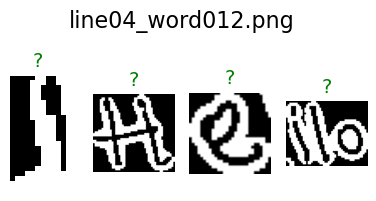


🔍 Processing: line04_word013.png
🧪 Skeleton shape: (78, 90) | White pixels: 1186
✂️ Segments found: 3
🔤 Predicted: ???


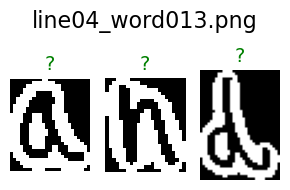


🔍 Processing: line04_word014.png
🧪 Skeleton shape: (111, 93) | White pixels: 1874
✂️ Segments found: 2
🔤 Predicted: ??


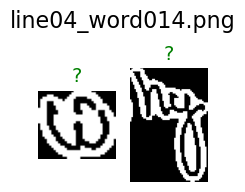


🔍 Processing: line04_word015.png
🧪 Skeleton shape: (64, 76) | White pixels: 1110
✂️ Segments found: 1
🔤 Predicted: ?


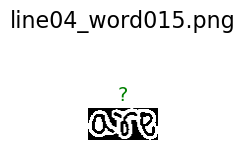


🔍 Processing: line04_word016.png
🧪 Skeleton shape: (94, 114) | White pixels: 1850
✂️ Segments found: 1
🔤 Predicted: ?


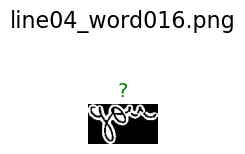

In [52]:
path = r"C:\Users\JAI SHREE KRISHNA\Major Project\cropped_words"
run_pipeline(path)  # Replace with your folder path

Found 17 images.
line01_word000.png → ??


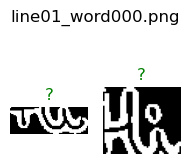

line01_word001.png → ?


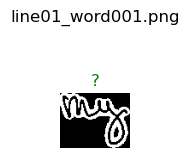

line01_word002.png → ?


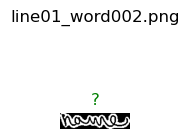

line01_word003.png → ?


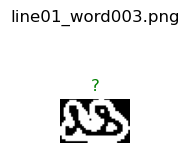

line01_word004.png → ???


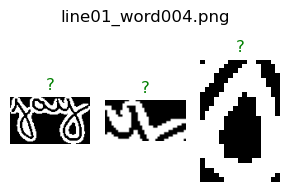

line02_word005.png → ?


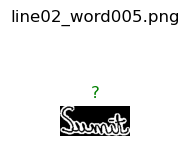

line02_word006.png → ?


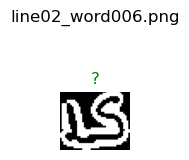

line02_word007.png → ?


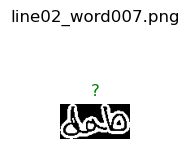

line02_word008.png → ??


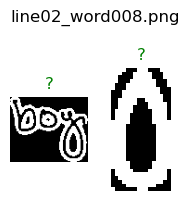

line03_word009.png → ?


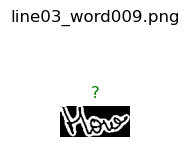

line03_word010.png → ?


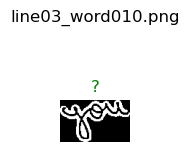

line03_word011.png → ??


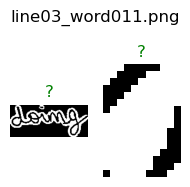

line04_word012.png → ???


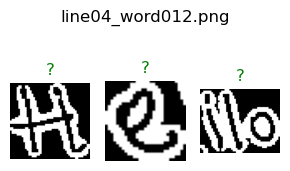

line04_word013.png → ???


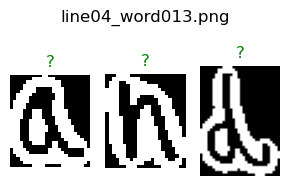

line04_word014.png → ??


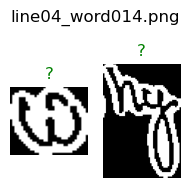

line04_word015.png → ?


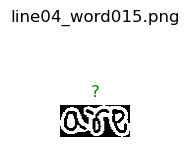

line04_word016.png → ?


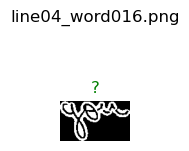

In [4]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image_array(img):
    # 1) Grayscale (if needed)
    gray = img if img.ndim==2 else cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Adaptive threshold → white text on black
    binary = cv2.adaptiveThreshold(gray,255,
               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
               cv2.THRESH_BINARY_INV,15,8)
    # 3) Clean small specks
    kernel = np.ones((2,2),np.uint8)
    return cv2.morphologyEx(binary,cv2.MORPH_OPEN,kernel)

def contour_segmentation(binary_img, min_area=100):
    # Find external contours (characters)
    cnts,_ = cv2.findContours(binary_img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    boxes = [cv2.boundingRect(c) for c in cnts if cv2.contourArea(c)>=min_area]
    # Sort left→right and crop
    boxes = sorted(boxes, key=lambda b: b[0])
    return [binary_img[y:y+h, x:x+w] for (x,y,w,h) in boxes]

def predict_character(img):
    # stub for your model
    # e.g. resize to 28×28, normalize, then model.predict…
    return "?"

def visualize_segments(segments, preds, title):
    plt.figure(figsize=(len(segments),2))
    for i,seg in enumerate(segments):
        plt.subplot(1,len(segments),i+1)
        plt.imshow(seg, cmap='gray'); plt.axis('off')
        plt.title(preds[i], color='green')
    plt.suptitle(title); plt.tight_layout(); plt.show()

def run_pipeline(folder):
    imgs = glob.glob(os.path.join(folder, "*.png"))
    print(f"Found {len(imgs)} images.")
    for p in sorted(imgs):
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if img is None: continue
        binarized = preprocess_image_array(img)
        chars = contour_segmentation(binarized)
        preds = [predict_character(c) for c in chars]
        print(os.path.basename(p), "→", "".join(preds))
        visualize_segments(chars, preds, os.path.basename(p))

# Usage:
run_pipeline(r"C:\Users\JAI SHREE KRISHNA\Major Project\cropped_words")
